In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/main/dataset/Netflix%20Stock%20Price/NFLX.csv")
data[0:3]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
1,2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002,17284900
2,2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997,17948100


In [5]:
fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=data['Date'],y=data['Open'].rolling(window=14).mean(),name="netflix"),secondary_y=False,)
fig.update_layout(autosize=False,width=700,height=500,title_text="NETFLIX")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices",secondary_y=False)
fig.show()

In [6]:
n=len(data)
train_data=data[0:(n//10)*9]
test_data=data[(n//10)*9:]
test_data[0:3]

,Date,Open,High,Low,Close,Adj Close,Volume
900,2019-07-17,366.250000,366.500000,361.750000,362.440002,362.440002,13639500
901,2019-07-18,323.760010,329.850006,320.299988,325.209991,325.209991,31305900
902,2019-07-19,323.399994,325.850006,314.230011,315.100006,315.100006,16302500


In [7]:
print(len(train_data))
print(len(test_data))

900
107


In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_data['Open'].values.reshape(-1,1))
prediction_days = 30

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)-10):      ######
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+10, 0])      ###### predict 10 days after
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)

(860, 30, 1)
(860,)


In [9]:
def LSTM_model():
    
    model = Sequential()    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    return model
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])   

2022-06-14 22:51:09.083567: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [10]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 1, save_best_only = True)
his=model.fit(x_train,y_train,epochs=20,batch_size=32,callbacks=[checkpointer])

2022-06-14 22:51:20.038196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
27/27 [==============================] - 8s 69ms/step - loss: 0.0576 - accuracy: 0.0012
Epoch 2/20
27/27 [==============================] - 2s 75ms/step - loss: 0.0096 - accuracy: 0.0012
Epoch 3/20
27/27 [==============================] - 2s 75ms/step - loss: 0.0083 - accuracy: 0.0012
Epoch 4/20
27/27 [==============================] - 2s 70ms/step - loss: 0.0076 - accuracy: 0.0012
Epoch 5/20
27/27 [==============================] - 2s 70ms/step - loss: 0.0072 - accuracy: 0.0012
Epoch 6/20
27/27 [==============================] - 2s 73ms/step - loss: 0.0067 - accuracy: 0.0012
Epoch 7/20
27/27 [==============================] - 2s 70ms/step - loss: 0.0080 - accuracy: 0.0012
Epoch 8/20
27/27 [==============================] - 2s 73ms/step - loss: 0.0074 - accuracy: 0.0012
Epoch 9/20
27/27 [==============================] - 2s 86ms/step - loss: 0.0067 - accuracy: 0.0012
Epoch 10/20
27/27 [==============================] - 2s 70ms/step - loss: 0.0070 - accuracy: 0.0012
Epoch 11/

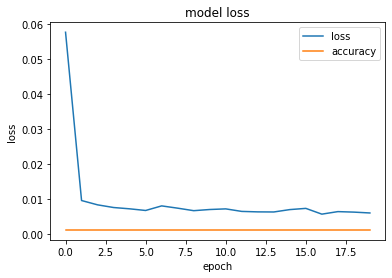

In [11]:
plt.plot(his.history['loss'])
plt.plot(his.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'], loc='upper right')
plt.show()

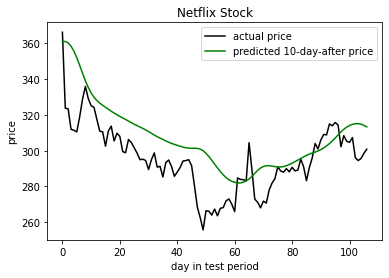

(1, 29, 1)


In [12]:
actual_prices = test_data['Open'].values
total_dataset = pd.concat((train_data['Open'], test_data['Open']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)
x_test = []
for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
plt.plot(actual_prices, color='black', label=f"actual price")
plt.plot(predicted_prices, color= 'green', label=f"predicted 10-day-after price")
plt.title(f"Netflix Stock")
plt.xlabel("day in test period")
plt.ylabel(f"price")
plt.legend()
plt.show()

real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))
print(real_data.shape)

In [13]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction[0][0]}")

prediction: 312.5185546875
